This script is a practice of applying CNN for sentence polarity classification. The goal for myself is to reproduce [Yoon Kim (2014)](https://arxiv.org/pdf/1408.5882.pdf)'s results on Rotten Tomatoes' movie reviews to get my hands dirty on CNN/TensorFlow. This goal, though, was unexpectedly tough to achieve. The [author's source code](https://github.com/yoonkim/CNN_sentence) is in Keras. [Denny Britz](https://github.com/dennybritz/cnn-text-classification-tf) has a TensorFlow implementation but it is too advanced for beginners. In addition, all the novice-friendly CNN codes are for images, giving me a real hard time translating the image context to text. 

Therefore, another goal of this script is to provide a beginner-friendly TensorFlow implementation of CNN on text. The script mimicked ** [Hvass-Labs' CNN tutorial](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/02_Convolutional_Neural_Network.ipynb) (here is the [video tutorial](https://www.youtube.com/watch?v=HMcx-zY8JSg&t=1503s); the whole series is HIGHLY RECOMMEND for TensoFlow/DeepLearning absolute beginners)**. If you unfortunately decide to pick up CNN from modeling text, hopefully this script can be of some help to you.



In [1]:
import tensorflow as tf
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

import helper
import numpy as np
from datetime import datetime

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

### Set parameters

In [2]:
TRAINED_WORDVEC = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [85]:
WORDVEC_LEN = TRAINED_WORDVEC.syn0.shape[1]   # 300
WORDS_PER_DOC = 50

DOC_SHAPE = (WORDS_PER_DOC, WORDVEC_LEN) 
DOC_FLATTEN_LEN = WORDVEC_LEN * WORDS_PER_DOC
NUM_CLASSES = 2

NUM_CHANNELS = 1
FILTER_HEIGHT = [3,4,5]   # Unlike in images, filter on word embedding should always be 
                          # as wide as the embedding; varying the size of the filter really is 
                          # just changing the height
DORPOUT_KEEP_PROB = 0.5

BATCH_SIZE = 100

### Read in training data

In [61]:
neg = []
with open("rt/rt-polarity.neg") as f:
    for line in f:
        txt = helper.txt_to_words(line.strip(),remove_stopwords=False)
        label = [0,1]
        length = len(txt)
        neg.append([txt,label,length])
        
pos = []
with open("rt/rt-polarity.pos") as f:
    for line in f:
        txt = helper.txt_to_words(line.strip(),remove_stopwords=False)
        label = [1,0]
        length = len(txt)
        pos.append([txt,label,length])

In [62]:
neg_array = np.array(neg)
pos_array = np.array(pos)

In [63]:
rt = np.concatenate([neg_array, pos_array], axis=0)
print(rt.shape)
print("---> X:\n", rt[:3,0])
print("---> y:\n", rt[:3,1])

(10662, 3)
---> X:
 [['simplistic', 'silly', 'and', 'tedious']
 ['it', "'s", 'so', 'laddish', 'and', 'juvenile', 'only', 'teenage', 'boys', 'could', 'possibly', 'find', 'it', 'funny']
 ['exploitative', 'and', 'largely', 'devoid', 'of', 'the', 'depth', 'or', 'sophistication', 'that', 'would', 'make', 'watching', 'such', 'a', 'graphic', 'treatment', 'of', 'the', 'crimes', 'bearable']]
---> y:
 [[0, 1] [0, 1] [0, 1]]


Max doc length:  53


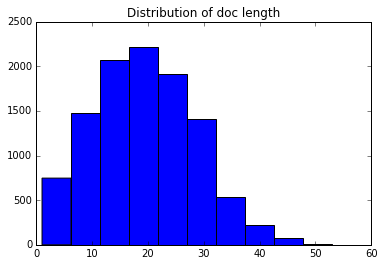

In [64]:
# Distrubiton of doc length
plt.hist(rt[:,2].astype(int))
plt.title("Distribution of doc length")
print("Max doc length: ",np.max(rt[:,2]))

In [65]:
np.random.shuffle(rt)
X_train, X_test, y_train, y_test = train_test_split(rt[:,0],rt[:,1],test_size = 0.1, random_state =1)

In [67]:
# Fix dimension of y - make it one-hot encoding
print("---> Before:")
print(y_train.shape)
print(y_train)
y_train = np.array(y_train.tolist())
y_test = np.array(y_test.tolist())

print("---> After:")
print(y_train.shape)
print(y_train)

---> Before:
(9595,)
[[1, 0] [1, 0] [1, 0] ..., [1, 0] [0, 1] [1, 0]]
---> After:
(9595, 2)
[[1 0]
 [1 0]
 [1 0]
 ..., 
 [1 0]
 [0 1]
 [1 0]]


### Configure a simple CNN
    * 1 convolutional layer (with drop out)
    * 1 fully connected layer (with l2 regularization)

#### Helper funtions

In [9]:
# Helper to get a parameters to optimize
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def new_biases(length):
    return tf.Variable(tf.constant(0.05,shape =[length]))

In [83]:
# Configure the convolutional layer
def new_conv_layer(input_tensor_4d,
                  num_channels,
                  filter_heights,
                  filter_width,
                  num_filters,
                  use_pooling=True):
    # input_tensor_4d should be a 4D tensor
    # input_tensor_4d's dimension = [docs_per_batch, row/words_per_doc, col/latentdims_per_word, num_channels]
    
    # Create a list for each filter size; 
    # We have 3 filter sizes of 3,4,5 here, so we'll end up with 3 elemets
    # each element is a 4D tensor of [1,1,1,num_filters]
    conv_per_filter_size = []
    
    for filter_height in filter_heights:
    
        shape_filter = [filter_height, filter_width, num_channels, num_filters]

        # Params to learn & optimize
        weights = new_weights(shape=shape_filter)
        biases = new_biases(length=num_filters)

        # Construct the conv layer and compute output
        conv_1filter_4d = tf.nn.conv2d(input=input_tensor_4d,
                                     filter=weights,
                                     strides=[1,1,1,1],  # strides[1,2]: step size rowwise and colwise
                                     padding='VALID')    # VALID: no padding 
        # Add bias
        conv_1filter_4d = tf.nn.bias_add(conv_1filter_4d,biases)

        # Max-over pooling: take the largest value per filter
        conv_1filter_4d = tf.nn.max_pool(value=conv_1filter_4d,
                                       ksize=[1,input_tensor_4d.get_shape()[1]- filter_height + 1,1,1],  
                                       # window size over which to calculate the max value
                                       strides=[1,1,1,1],
                                       padding="VALID")

        # ReLU - change negative values in the conv output to 0
        conv_1filter_4d = tf.nn.relu(conv_1filter_4d)
        
        conv_per_filter_size.append(conv_1filter_4d)
    
    # Concatenate the result for each filter size
    conv_layer_4d = tf.concat(conv_per_filter_size,axis=3) 
    
    return conv_layer_4d,weights

In [11]:
# flattern the conv layer output from 4D to 2D to feed to the final fully-connected layer
def flatten_layer(conv_layer_tensor_4d):
    
    layer_shape = conv_layer_tensor_4d.get_shape()
    
    num_features = layer_shape[1:4].num_elements()
    
    layer_2d = tf.reshape(conv_layer_tensor_4d, [-1,num_features])
    # layer_2d is [docs_per_batch, row/words_per_doc * col/latentdims_per_word * num_channels]
    # in the text example, row/words_per_doc = col/latentdims_per_word = 1
    
    return layer_2d, num_features

In [90]:
# Add a drop out
def dropout_layer(input_tensor_2d):
    return tf.nn.dropout(input_tensor_2d, keep_prob = DROPOUT_KEEP_PROB)

In [13]:
def new_fc_layer(input_tensor_2d,
                num_inputs,
                num_outputs):
    weights = new_weights(shape=[num_inputs,num_outputs])
    biases = new_biases(length=num_outputs)
    
    layer_2d = tf.matmul(input_tensor_2d,weights) + biases
    
    return layer_2d,weights

#### Build the "Framework"
##### 1. Input - training X and y

In [14]:
x_doc_vec = tf.placeholder(tf.float32, shape=[None, DOC_FLATTEN_LEN])
x_doc_vec_to_4d_tensor = tf.reshape(x_doc_vec, shape=[-1,WORDS_PER_DOC,WORDVEC_LEN,1])

y_true = tf.placeholder(tf.float32, shape = [None,2]) # One-hot encoded
y_true_cls = tf.argmax(y_true, dimension=1)

##### 2. Build the network

In [88]:
# The first layer: convolutional layer with pooling
# We have 3 filter size, using 100 filters for each will give us 300 filters
layer1_conv1, weights_layer1 = new_conv_layer(input_tensor_4d=x_doc_vec_to_4d_tensor,
                                          num_channels=1,
                                          filter_heights=FILTER_HEIGHT,
                                          filter_width=WORDVEC_LEN,
                                          num_filters=100,
                                          use_pooling=True)

layer1_conv1 # 4D (It's in fact 2D, since it reduces to 1 number per doc per filter)

<tf.Tensor 'concat_2:0' shape=(?, 1, 1, 300) dtype=float32>

In [91]:
# Flatten the convolutional layer
layer1_conv1_2d, num_features= flatten_layer(layer1_conv1)
layer1_conv1_2d

<tf.Tensor 'Reshape_5:0' shape=(?, 300) dtype=float32>

In [ ]:
# Implement a dropout on the flattened convolutional layer
# After dropout, the shape of the tensor remains the same 
# - only 50% of values are "turned off" (set to 0) with DROPOUT_KEEP_PROB = 0.5
layer1_conv1_2d_dropout = dropout_layer(layer1_conv1_2d)

In [92]:
# The second layer: fully-connected layer
layer2_fc1, weights_layer2 = new_fc_layer(input_tensor_2d=layer1_conv1_2d_dropout,
                                         num_inputs=num_features,
                                         num_outputs=2)

layer2_fc1

<tf.Tensor 'add_1:0' shape=(?, 2) dtype=float32>

In [93]:
# Prediction
y_pred = tf.nn.softmax(layer2_fc1)
y_pred_cls = tf.argmax(y_pred,dimension=1)
y_pred

<tf.Tensor 'Softmax_1:0' shape=(?, 2) dtype=float32>

In [94]:
# Cost function to be optimized
# TF built-in function calculates the softmax internally 
# so we must use the output of layer_fc2 directly rather than y_pred which has already had the softmax applied.
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer2_fc1,
                                                        labels=y_true)
loss = tf.reduce_mean(cross_entropy)

In [95]:
# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(loss)

In [96]:
# Performance Measures
correct_prediction = tf.equal(y_true_cls,y_pred_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Feed in the data and optimize

In [97]:
batches = helper.generate_batch_indices(batch_size=BATCH_SIZE,
                                        data_size=len(X_train))
total_iterations = 0
#train_array[batches[0]]

In [98]:
def optimize(num_iterations):
    global total_iterations
    global batches
    
    t0 = datetime.now()
    
    for i in range(total_iterations, total_iterations + num_iterations):
        
        if i >= len(batches):
            # Shuffle and generate new batches
            batches = helper.generate_batch_indices(batch_size=BATCH_SIZE,
                                                    data_size=X_train.shape[0])
            multiplier = i // len(batches)
            
            batch = batches[i - multiplier*len(batches)]
            
        else:
            batch = batches[i]
            
        y_true_onehot_batch = y_train[batch]
        x_batch = helper.create_X_rt(X_train[batch],
                                     trained_wordvec=TRAINED_WORDVEC,
                                     words_per_doc = WORDS_PER_DOC,
                                     wordvec_len = WORDVEC_LEN)
        
        feed_dict_train = {
            x_doc_vec: x_batch,
            y_true: y_true_onehot_batch
        }
        
        session.run(optimizer, feed_dict = feed_dict_train)
        
        if i % 90 == 0:
            # Calculate the accuracy on the training-set.
            acc = session.run(accuracy, feed_dict=feed_dict_train)

            # Message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

            # Print it.
            print(msg.format(i + 1, acc))
        
    total_iterations += num_iterations
    
    t1 = datetime.now() - t0
    print(t1)

In [99]:
session = tf.Session() # start a session
session.run(tf.global_variables_initializer()) # initialize all the variables

### Test accuracy

In [100]:
batches_test = helper.generate_batch_indices(batch_size=BATCH_SIZE,data_size=X_test.shape[0])

In [101]:
def predict_on_test():
    
    global batches_test
    
    t0 = datetime.now()
    
    y_true_cls = np.argmax(y_test, axis=1)  # Row-wise
    y_pred = np.zeros(y_test.shape[0])
    
    for i in range(len(batches_test)):
        
        x_batch = helper.create_X_rt(X_test[batches_test[i]],
                                     trained_wordvec=TRAINED_WORDVEC,
                                     words_per_doc = WORDS_PER_DOC,
                                     wordvec_len = WORDVEC_LEN)
        feed_dict_test = {
            x_doc_vec: x_batch
        }
        
        y_pred[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = session.run(y_pred_cls,
                                                            feed_dict=feed_dict_test)
     
    correct = (y_true_cls==y_pred)
    
    accuracy = float(sum(correct)) / X_test.shape[0]
    
    print("# of iterations: ", total_iterations)
     # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(accuracy, sum(correct), X_test.shape[0]))
    print(datetime.now() - t0)
    

In [102]:
predict_on_test()

# of iterations:  0
Accuracy on Test-Set: 49.6% (529 / 1067)
0:00:02.989496


In [ ]:
optimize(num_iterations=90)  # 90 * 100 = 9000, ~1 epoch
predict_on_test()

Optimization Iteration:      1, Training Accuracy:  77.0%
0:01:16.675955
# of iterations:  90
Accuracy on Test-Set: 48.6% (519 / 1067)
0:00:02.880818


In [ ]:
counter = 0

while counter < 10:
    optimize(900)
    predict_on_test()
    print()
    
    counter += 1

Optimization Iteration:     91, Training Accuracy:  68.0%
Optimization Iteration:    181, Training Accuracy:  89.0%
Optimization Iteration:    271, Training Accuracy:  91.0%
Optimization Iteration:    361, Training Accuracy:  93.0%
Optimization Iteration:    451, Training Accuracy:  98.0%
Optimization Iteration:    541, Training Accuracy: 100.0%
Optimization Iteration:    631, Training Accuracy: 100.0%
Optimization Iteration:    721, Training Accuracy: 100.0%
Optimization Iteration:    811, Training Accuracy: 100.0%
Optimization Iteration:    901, Training Accuracy: 100.0%
0:12:13.554065
# of iterations:  990
Accuracy on Test-Set: 47.0% (501 / 1067)
0:00:02.793208

Optimization Iteration:    991, Training Accuracy: 100.0%
Optimization Iteration:   1081, Training Accuracy: 100.0%
